In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# data loading and presentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
train_df= pd.read_csv("../input/digit-recognizer/train.csv")
test_df= pd.read_csv("../input/digit-recognizer/test.csv")

In [4]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.shape

(42000, 785)

1
0
1
4
0
0
7
3


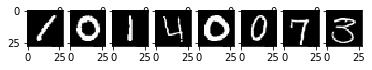

In [8]:
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(train_df.iloc[i,1:].values.reshape(28,28),cmap= "gray")
    print(train_df.iloc[i,0])

In [ ]:
#train_df.iloc[1:10,1:].plot(kind="hist")

the values of each pixels is 0-255, we'd better normalize. Torch.utils.data.Dataset is a conventional tool
for loading the data provided by pytorch
It is an abstract class representing a dataset. Your custom dataset should inherit dataset and override the following methods:
* __len__ so that len(dataset) returns the size of the dataset
* __getitem__ to support the indexing such that datasrt can be used to get ith sample


In [16]:
class MNIST_dataset(Dataset):
    def __init__(self, df, rows= 42000):
        self.imgnp= df.iloc[:rows,1:].values
        self.labels= df.iloc[:rows, 0].values
        self.rows= rows
        
    def __len__(self):
        return(self.rows)
    
    def __getitem__(self, idx):
        image= torch.tensor(self.imgnp[idx], dtype=torch.float)/255 # NORMALIZE
        image= image.view(1,28,28) # (CHANNEL,HEIGHT,WIDTH)
        label= self.labels[idx]
        return(image, label)
        

In [17]:
trainloader= DataLoader(MNIST_dataset(train_df,42000), batch_size=4, shuffle= True)

In [21]:
dataiter= iter(trainloader)

In [23]:
images, labels= dataiter.next()

In [26]:
images.size(), labels.size()

(torch.Size([4, 1, 28, 28]), torch.Size([4]))

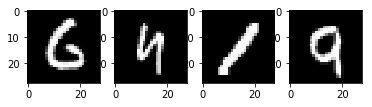

In [28]:
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i,0], cmap="gray")

## DEFINING A CONVOLUTIONAL NEURAL NETWORK

In [32]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1= nn.Conv2d(1,6,5)
        self.pool= nn.MaxPool2d(2,2)
        self.conv2= nn.Conv2d(6,16,5)
        self.fc1= nn.Linear(16*4*4, 120)
        self.fc2= nn.Linear(120, 84)
        self.fc3= nn.Linear(84,10)
    def forword(self,x):
        x= self.pool(F.relu(self.conv1(x)))
        x= self.pool(F.relu(self.conv2(x)))
        x= x.view(-1,16*4*4)
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        return(x)

In [33]:
net= Network()

In [34]:
# LOSS FUNCTION
criterion= nn.CrossEntropyLoss()
optimizer= optim.SGD(net.parameters(), lr= 0.001, momentum= 0.9)

* Lr parameter is a very important one as its small value will make the training very slow and
larger value very fast, but we need something which makes the learning smooth for avoiding global minima.

### Train the network on the training data

In [38]:
running_loss_list= []
for epoch in range(2):
    running_loss= 0
    for i, data in enumerate(trainloader,0):
        inputs, labels= data
        optimizer.zero_grad()
        outputs= net(inputs)
        loss= criterion(outputs, labels)
        loss.backword()
        optimizer.step()
        running_loss+= loss.item()
        if(i%800==799):
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 800)
                 )
            running_loss_list.append(running_loss)
            running_loss = 0.0
print('Finished Training')            
        

NotImplementedError: 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on train images: ', correct/total)